In [195]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [196]:
def load_dataset(path):
    df = pd.read_csv(path)
    dataset = df.to_numpy()

    return dataset

In [197]:
#Load data
X = load_dataset('D:/HomeWork/NN/HW3/UCI HAR Dataset/train/X_train.csv')
y = load_dataset('D:/HomeWork/NN/HW3/UCI HAR Dataset/train/y_train.csv')
X_test = load_dataset('D:/HomeWork/NN/HW3/UCI HAR Dataset/test/X_test.csv')
y_test = load_dataset('D:/HomeWork/NN/HW3/UCI HAR Dataset/test/y_test.csv')
y = y-1
y_test = y_test-1

#split data to train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=42)

In [190]:
class SOM:
    def __init__(self, map_size, lr=0.1):
        """
        Args:
            map_size : [map_w, map_h, f=16]
        """
        self.map = np.random.random(size=(map_size[0], map_size[1], map_size[2]))

        self.lr0 = lr
        self.lr = self.lr0

        self.R0 = map_size[0] // 2
        self.R = self.R0

    def train(self, X, y, T=1000, error_threshold=10**-20):
        # Loss history
        Js = []
        winners = []
        dead_neurons = []
        neuos = np.zeros(shape=(self.map.shape[0], self.map.shape[1], 6))
        
        for t in range(T):
            prev_map = self.map.copy()
            # Shuffle X in every iteration
            shuffle_ind = np.random.randint(0, X.shape[0], X.shape[0])
            avg = (0 , 0)
            scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1], 1))
            
            for i in range(len(X)):
                x = X[shuffle_ind[i], :]
                # Neuron with most compatibilty with x
                winner = self.find_winner(x)
                scores[winner[0], winner[1]] += 1
                neuos[winner[0] , winner[1]] += to_categorical(y[i],num_classes=6)[0]
                avg = tuple(map(sum, zip(avg, winner)))
                avg = tuple(ti/2 for ti in avg)
                # Get all neurons in the neighborhood of winner
                NS = self.get_NS(winner)
                # Update weights of all neurons in the neighborhood of winner
                self.update_weights(x, winner, NS, len(X))
            
            
            dead_neurons.append(self.find_dead_neurons(scores))
            winners.append(np.linalg.norm(avg[0] - avg[1]))
            # Update learning rate and neighborhood radius (linear decay)
            self.lr = self.lr0 * (1 - t / T)
            self.R = self.R0 * (1 - t / T)


            Js.append(np.linalg.norm(prev_map - self.map))

            if t%10 == 0 or t == T-1:
                print(f"Iteration: {t}, Loss: {Js[-1]:.4f}, lr: {self.lr:.4f}, R: {self.R:.4f}")
            
            if Js[-1] < error_threshold:
                print("MIN CHANGE")
                break

        return Js , winners , dead_neurons , neuos
    
    def find_winner(self, x):
        rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        dists = np.sum((self.map - rep_x) ** 2, axis=2)
        winner = np.unravel_index(np.argmin(dists, axis=None), shape=dists.shape)
        return winner
    
    def find_dead_neurons(self , x):
        x = np.array(x)
        count = np.count_nonzero(x==0)
        return count
        

    def get_NS(self, winner):
        # NS: Neighborhood strength
        NS = np.zeros((self.map.shape[0], self.map.shape[1]))

        # winner i,j
        iw, jw = winner[0], winner[1]
        
        NS[iw, jw] = 1 # Winner

        # Circular neighborhood
        R = int(self.R)
        for ri in range(-R, R):
            for rj in range(-R, R):
                if 0 <= iw + ri < self.map.shape[0] and 0 <= jw + rj < self.map.shape[1]:
                    NS[iw + ri, jw + rj] = 0 if np.sqrt(ri**2 + rj**2)>R else 1/(1+np.sqrt(ri**2 + rj**2))
        
        return NS

    def update_weights(self, x, winner, n_strength, X_len):
        # Note: n_strength is already W*H we just need to make it W*H*f
        NS = np.tile(n_strength, (self.map.shape[2], 1, 1)).transpose()

        # Difference between inputs and neurons
        rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        Delta = rep_x - self.map

        # Update weights
        self.map = self.map + (self.lr/X_len) * np.multiply(NS, Delta)
    
    def extract_features(self, x):
        rep_x = np.tile(x, (self.map.shape[0], self.map.shape[1], 1))
        dists = np.sum((self.map - rep_x) ** 2, axis=2)
        return 1/(1+dists)
    
    def get_umatrix(self): 

        umatrix = np.zeros((self.map.shape[0], self.map.shape[1]))
        
        
        
        for map_x in range(self.map.shape[0]):
            for map_y in range(self.map.shape[1]):                

                n_dist = 0 
                total_dist = 0
                
                # Circular neighborhood
                for ri in range(-1, 2):
                    for rj in range(-1, 2):
                        if 0 <= map_x + ri < self.map.shape[0] and 0 <= map_y + rj < self.map.shape[1]:
                            dist = np.linalg.norm(self.map[map_x, map_y] - self.map[map_x + ri, map_y + rj])
                            if dist != 0:
                                total_dist += dist 
                                n_dist += 1

                avg_dist = total_dist / n_dist
                umatrix[map_x, map_y] = avg_dist
                
        return umatrix 

Iteration: 0, Loss: 3.9308, lr: 0.1000, R: 4.0000
Iteration: 10, Loss: 2.8214, lr: 0.0998, R: 3.9920
Iteration: 20, Loss: 2.2072, lr: 0.0996, R: 3.9840
Iteration: 30, Loss: 1.7728, lr: 0.0994, R: 3.9760
Iteration: 40, Loss: 1.4667, lr: 0.0992, R: 3.9680
Iteration: 50, Loss: 1.2122, lr: 0.0990, R: 3.9600
Iteration: 60, Loss: 1.0499, lr: 0.0988, R: 3.9520
Iteration: 70, Loss: 0.9649, lr: 0.0986, R: 3.9440
Iteration: 80, Loss: 0.8399, lr: 0.0984, R: 3.9360
Iteration: 90, Loss: 0.7710, lr: 0.0982, R: 3.9280
Iteration: 100, Loss: 0.7034, lr: 0.0980, R: 3.9200
Iteration: 110, Loss: 0.6884, lr: 0.0978, R: 3.9120
Iteration: 120, Loss: 0.6840, lr: 0.0976, R: 3.9040
Iteration: 130, Loss: 0.6492, lr: 0.0974, R: 3.8960
Iteration: 140, Loss: 0.5902, lr: 0.0972, R: 3.8880
Iteration: 150, Loss: 0.5616, lr: 0.0970, R: 3.8800
Iteration: 160, Loss: 0.5555, lr: 0.0968, R: 3.8720
Iteration: 170, Loss: 0.5234, lr: 0.0966, R: 3.8640
Iteration: 180, Loss: 0.4853, lr: 0.0964, R: 3.8560
Iteration: 190, Loss: 0

Iteration: 1570, Loss: 0.0253, lr: 0.0686, R: 2.7440
Iteration: 1580, Loss: 0.0245, lr: 0.0684, R: 2.7360
Iteration: 1590, Loss: 0.0224, lr: 0.0682, R: 2.7280
Iteration: 1600, Loss: 0.0232, lr: 0.0680, R: 2.7200
Iteration: 1610, Loss: 0.0233, lr: 0.0678, R: 2.7120
Iteration: 1620, Loss: 0.0232, lr: 0.0676, R: 2.7040
Iteration: 1630, Loss: 0.0201, lr: 0.0674, R: 2.6960
Iteration: 1640, Loss: 0.0237, lr: 0.0672, R: 2.6880
Iteration: 1650, Loss: 0.0214, lr: 0.0670, R: 2.6800
Iteration: 1660, Loss: 0.0235, lr: 0.0668, R: 2.6720
Iteration: 1670, Loss: 0.0227, lr: 0.0666, R: 2.6640
Iteration: 1680, Loss: 0.0220, lr: 0.0664, R: 2.6560
Iteration: 1690, Loss: 0.0226, lr: 0.0662, R: 2.6480
Iteration: 1700, Loss: 0.0224, lr: 0.0660, R: 2.6400
Iteration: 1710, Loss: 0.0214, lr: 0.0658, R: 2.6320
Iteration: 1720, Loss: 0.0224, lr: 0.0656, R: 2.6240
Iteration: 1730, Loss: 0.0211, lr: 0.0654, R: 2.6160
Iteration: 1740, Loss: 0.0200, lr: 0.0652, R: 2.6080
Iteration: 1750, Loss: 0.0186, lr: 0.0650, R: 

Iteration: 3120, Loss: 0.0096, lr: 0.0376, R: 1.5040
Iteration: 3130, Loss: 0.0093, lr: 0.0374, R: 1.4960
Iteration: 3140, Loss: 0.0091, lr: 0.0372, R: 1.4880
Iteration: 3150, Loss: 0.0089, lr: 0.0370, R: 1.4800
Iteration: 3160, Loss: 0.0093, lr: 0.0368, R: 1.4720
Iteration: 3170, Loss: 0.0086, lr: 0.0366, R: 1.4640
Iteration: 3180, Loss: 0.0093, lr: 0.0364, R: 1.4560
Iteration: 3190, Loss: 0.0086, lr: 0.0362, R: 1.4480
Iteration: 3200, Loss: 0.0079, lr: 0.0360, R: 1.4400
Iteration: 3210, Loss: 0.0085, lr: 0.0358, R: 1.4320
Iteration: 3220, Loss: 0.0082, lr: 0.0356, R: 1.4240
Iteration: 3230, Loss: 0.0081, lr: 0.0354, R: 1.4160
Iteration: 3240, Loss: 0.0083, lr: 0.0352, R: 1.4080
Iteration: 3250, Loss: 0.0087, lr: 0.0350, R: 1.4000
Iteration: 3260, Loss: 0.0084, lr: 0.0348, R: 1.3920
Iteration: 3270, Loss: 0.0079, lr: 0.0346, R: 1.3840
Iteration: 3280, Loss: 0.0080, lr: 0.0344, R: 1.3760
Iteration: 3290, Loss: 0.0077, lr: 0.0342, R: 1.3680
Iteration: 3300, Loss: 0.0078, lr: 0.0340, R: 

Iteration: 4670, Loss: 0.0010, lr: 0.0066, R: 0.2640
Iteration: 4680, Loss: 0.0010, lr: 0.0064, R: 0.2560
Iteration: 4690, Loss: 0.0009, lr: 0.0062, R: 0.2480
Iteration: 4700, Loss: 0.0009, lr: 0.0060, R: 0.2400
Iteration: 4710, Loss: 0.0009, lr: 0.0058, R: 0.2320
Iteration: 4720, Loss: 0.0009, lr: 0.0056, R: 0.2240
Iteration: 4730, Loss: 0.0008, lr: 0.0054, R: 0.2160
Iteration: 4740, Loss: 0.0008, lr: 0.0052, R: 0.2080
Iteration: 4750, Loss: 0.0008, lr: 0.0050, R: 0.2000
Iteration: 4760, Loss: 0.0007, lr: 0.0048, R: 0.1920
Iteration: 4770, Loss: 0.0007, lr: 0.0046, R: 0.1840
Iteration: 4780, Loss: 0.0007, lr: 0.0044, R: 0.1760
Iteration: 4790, Loss: 0.0007, lr: 0.0042, R: 0.1680
Iteration: 4800, Loss: 0.0006, lr: 0.0040, R: 0.1600
Iteration: 4810, Loss: 0.0006, lr: 0.0038, R: 0.1520
Iteration: 4820, Loss: 0.0006, lr: 0.0036, R: 0.1440
Iteration: 4830, Loss: 0.0005, lr: 0.0034, R: 0.1360
Iteration: 4840, Loss: 0.0005, lr: 0.0032, R: 0.1280
Iteration: 4850, Loss: 0.0005, lr: 0.0030, R: 

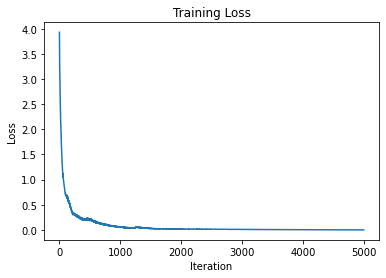

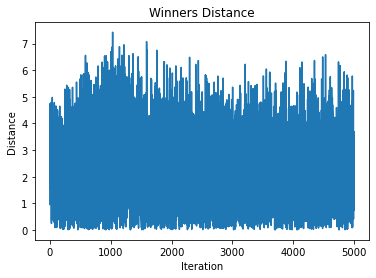

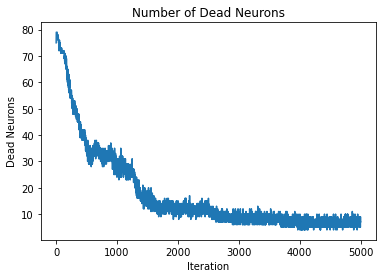

In [181]:

som_net = SOM(map_size=(9,9,X_valid.shape[1]))

# Loss
Js , winners , dead_neurons , neuos = som_net.train(X_valid, y, T=5000)
plt.plot(Js)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.plot(winners)
plt.title("Winners Distance")
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.show()

plt.plot(dead_neurons)
plt.title("Number of Dead Neurons")
plt.xlabel("Iteration")
plt.ylabel("Dead Neurons")
plt.show()


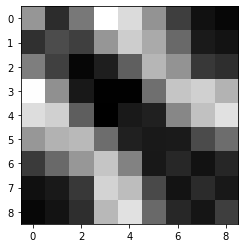

In [182]:
umatrix = som_net.get_umatrix()
plt.imshow(umatrix, cmap='gray')
plt.show()

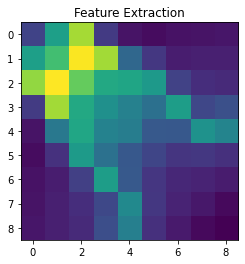

In [183]:
# Feature Extraction
x = X_train[0, :]
features = som_net.extract_features(x)
plt.imshow(features)
plt.title("Feature Extraction")
plt.show()

In [198]:
import tensorflow as tf
from pdb import set_trace as breakpoint
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

In [199]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [222]:
new_X_train = []
for item in X:
    features = som_net.extract_features(item)
    features = features.reshape(81)
    new_X_train.append(features)
    
new_X_test = []
for item in X_test:
    features = som_net.extract_features(item)
    features = features.reshape(81)
    new_X_test.append(features)

In [255]:
#split data to train and validation
X_train, X_valid, y_train, y_valid = train_test_split(new_X_train, y, test_size=0.10, random_state=42)

x_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
Y_train = to_categorical(y_train,num_classes=6)
Y_test = to_categorical(y_test,num_classes=6)

X_valid = pd.DataFrame(X_valid)
y_valid = pd.DataFrame(y_valid)
y_valid = to_categorical(y_valid,num_classes=6)



In [256]:
tb_callBack= keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq= 1)

In [274]:
model  = keras.models.Sequential([
                                  keras.Input(shape =(81,),name = 'input_layer'),
                                  keras.layers.Dense(units = 64 , activation='relu', name= 'hidden_layer1'),
                                  keras.layers.Dense(units = 128 , activation='relu', name= 'hidden_layer2'),
                                  keras.layers.Dense(6,activation='softmax',name='output_layer')
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.009),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train,Y_train,epochs= 20, validation_data =(X_valid, y_valid) , callbacks=[tb_callBack])

Epoch 1/20
207/207 [==============================] - 1s 2ms/step - loss: 0.6787 - accuracy: 0.6822 - val_loss: 0.4619 - val_accuracy: 0.8071
Epoch 2/20
207/207 [==============================] - 0s 2ms/step - loss: 0.4357 - accuracy: 0.8073 - val_loss: 0.4162 - val_accuracy: 0.7976
Epoch 3/20
207/207 [==============================] - 0s 2ms/step - loss: 0.3902 - accuracy: 0.8262 - val_loss: 0.3548 - val_accuracy: 0.8505
Epoch 4/20
207/207 [==============================] - 0s 2ms/step - loss: 0.3497 - accuracy: 0.8463 - val_loss: 0.3310 - val_accuracy: 0.8519
Epoch 5/20
207/207 [==============================] - 0s 2ms/step - loss: 0.3339 - accuracy: 0.8505 - val_loss: 0.3286 - val_accuracy: 0.8614
Epoch 6/20
207/207 [==============================] - 0s 2ms/step - loss: 0.3303 - accuracy: 0.8531 - val_loss: 0.3115 - val_accuracy: 0.8573
Epoch 7/20
207/207 [==============================] - 0s 2ms/step - loss: 0.3222 - accuracy: 0.8573 - val_loss: 0.3092 - val_accuracy: 0.8641
Epoch 

In [275]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (None, 64)                5248      
                                                                 
 hidden_layer2 (Dense)       (None, 128)               8320      
                                                                 
 output_layer (Dense)        (None, 6)                 774       
                                                                 
Total params: 14,342
Trainable params: 14,342
Non-trainable params: 0
_________________________________________________________________


In [225]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 6172), started 1 day, 6:34:04 ago. (Use '!kill 6172' to kill it.)